In [40]:
import torch
import torch_geometric


## Loading Dataset

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root = 'Citeseer', name = 'Citeseer')

In [41]:
data = dataset[0]
print(data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [42]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Size of labels: {data.y.size(0)}")
print(f"Number of classes: {dataset.num_classes}")


Number of nodes: 3327
Size of labels: 3327
Number of classes: 6


In [43]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5])

## EDA

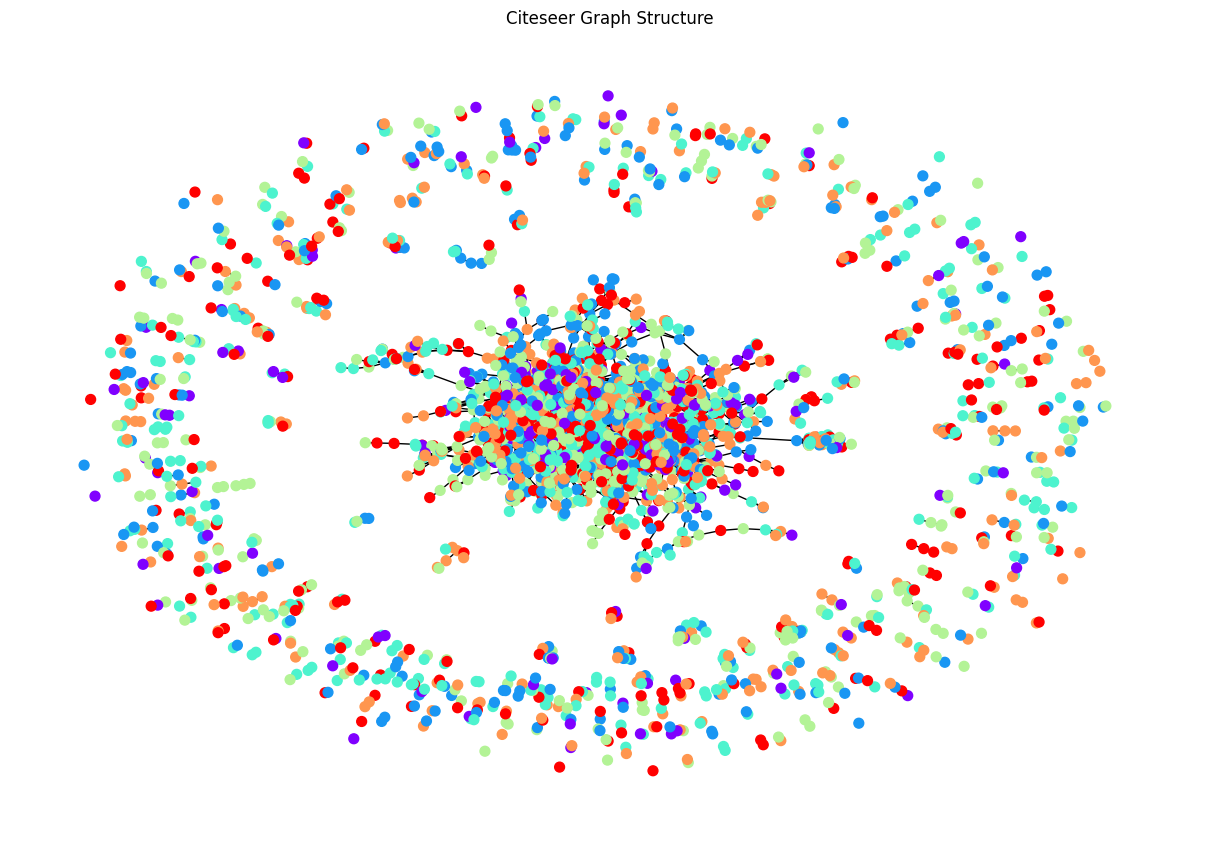

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
def visualize_graph(edge_index, labels, num_nodes):
    G = nx.Graph()
    edge_list = edge_index.t().tolist()  
    G.add_edges_from(edge_list)
    G.add_nodes_from(range(num_nodes)) 

    # Ensure labels match number of nodes
    labels = labels[:num_nodes]  # Truncate extra labels if necessary

    # Generate positions for the graph
    pos = nx.spring_layout(G, seed=42)  # Use spring layout for visualization

    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_color=labels,
        cmap=plt.cm.rainbow,
        node_size=50,
    )
    plt.title("Citeseer Graph Structure")
    plt.show()

# Call the function
visualize_graph(data.edge_index, data.y.numpy(), data.num_nodes)


In [45]:
print(data.edge_index)

tensor([[ 628,  158,  486,  ..., 2820, 1643,   33],
        [   0,    1,    1,  ..., 3324, 3325, 3326]])


In [46]:
class GCNLayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0))
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col] * norm.unsqueeze(-1))

        # # Debug intermediate output
        # print(f"Intermediate output (after aggregation): {out.shape}") 

        # # Apply linear transformation
        out = self.linear(out) 
        # print(f"Output after linear transformation: {out.shape}

        return out


In [47]:
class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_features, hidden_features)
        self.gcn2 = GCNLayer(hidden_features, out_features)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = self.relu(x)
        x = self.gcn2(x, edge_index)
        return self.softmax(x)


In [48]:
def train(model, data, optimizer, criterion, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data, mask):
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index).argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
    return acc


In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_features=data.num_features, hidden_features=16, out_features=dataset.num_classes).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

In [50]:
for epoch in range(100):
    loss = train(model, data, optimizer, criterion, data.train_mask)
    train_acc = test(model, data, data.train_mask)
    val_acc = test(model, data, data.val_mask)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1, Loss: 1.7985, Train Acc: 0.6000, Val Acc: 0.3200
Epoch 2, Loss: 1.6869, Train Acc: 0.6667, Val Acc: 0.3720
Epoch 3, Loss: 1.5183, Train Acc: 0.6167, Val Acc: 0.2920
Epoch 4, Loss: 1.3498, Train Acc: 0.6583, Val Acc: 0.2800
Epoch 5, Loss: 1.1861, Train Acc: 0.7667, Val Acc: 0.3180
Epoch 6, Loss: 1.0285, Train Acc: 0.8583, Val Acc: 0.3740
Epoch 7, Loss: 0.8793, Train Acc: 0.9083, Val Acc: 0.4220
Epoch 8, Loss: 0.7415, Train Acc: 0.9667, Val Acc: 0.4580
Epoch 9, Loss: 0.6189, Train Acc: 0.9750, Val Acc: 0.5000
Epoch 10, Loss: 0.5108, Train Acc: 0.9833, Val Acc: 0.5260
Epoch 11, Loss: 0.4168, Train Acc: 0.9917, Val Acc: 0.5580
Epoch 12, Loss: 0.3366, Train Acc: 0.9833, Val Acc: 0.5940
Epoch 13, Loss: 0.2696, Train Acc: 0.9833, Val Acc: 0.5900
Epoch 14, Loss: 0.2147, Train Acc: 0.9917, Val Acc: 0.5940
Epoch 15, Loss: 0.1705, Train Acc: 0.9917, Val Acc: 0.5960
Epoch 16, Loss: 0.1350, Train Acc: 1.0000, Val Acc: 0.5980
Epoch 17, Loss: 0.1067, Train Acc: 1.0000, Val Acc: 0.5940
Epoch 

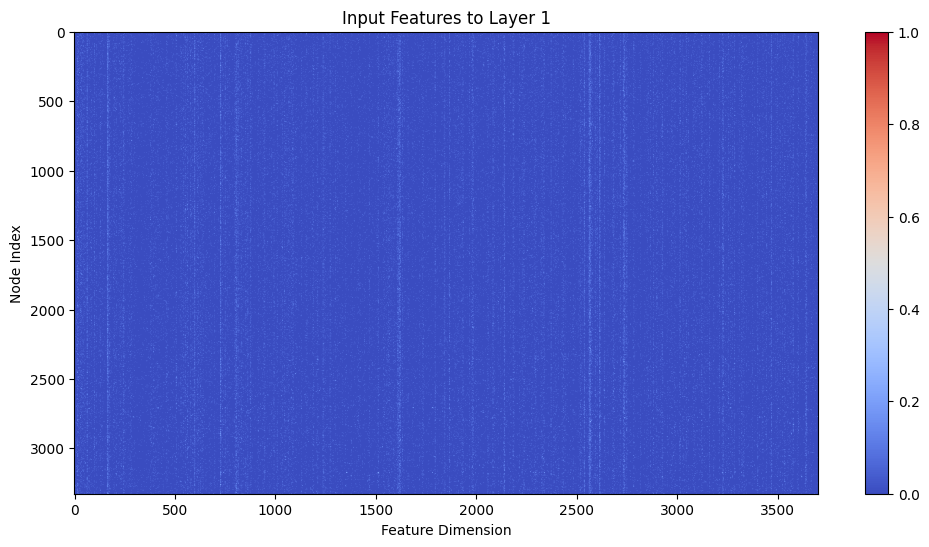

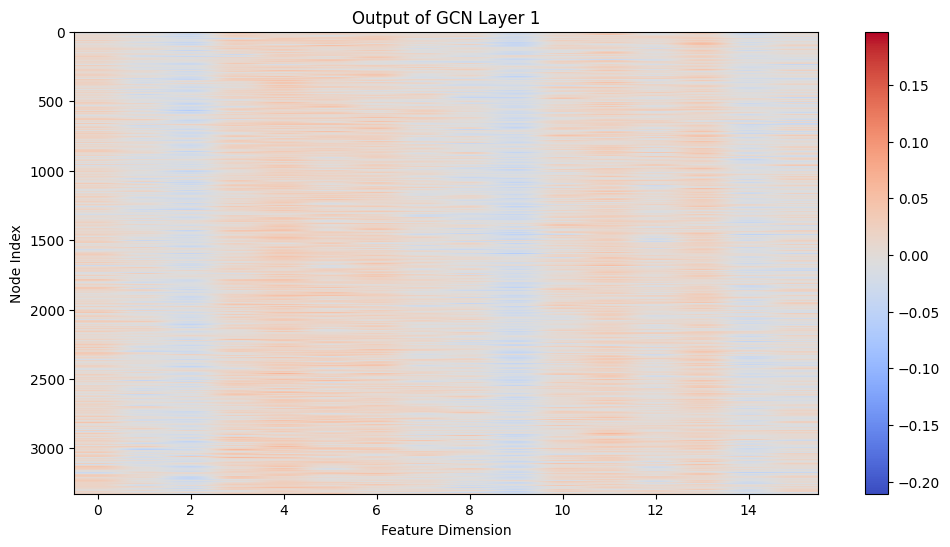

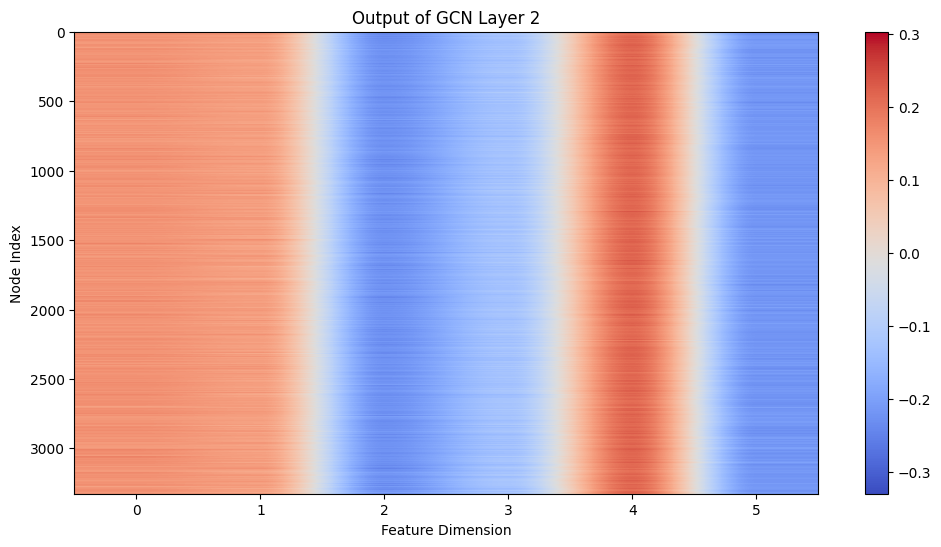

In [51]:
def visualize_features(features, title="Node Features"):
    plt.figure(figsize=(12, 6))
    plt.imshow(features, aspect='auto', cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Feature Dimension")
    plt.ylabel("Node Index")
    plt.show()

# visualize_features(data.x.numpy(), title="Original Node Features")

# Forward pass visualization
model = GCN(data.num_features, 16, dataset.num_classes)
with torch.no_grad():
    x = data.x
    visualize_features(x.numpy(), title="Input Features to Layer 1")
    x = model.gcn1(x, data.edge_index)
    visualize_features(x.numpy(), title="Output of GCN Layer 1")
    x = model.gcn2(x, data.edge_index)
    visualize_features(x.numpy(), title="Output of GCN Layer 2")


Epoch 1, Loss: 1.7948, Train Acc: 0.3667, Val Acc: 0.1220
Epoch 2, Loss: 1.6783, Train Acc: 0.7917, Val Acc: 0.3300
Epoch 3, Loss: 1.5138, Train Acc: 0.8917, Val Acc: 0.3460
Epoch 4, Loss: 1.3439, Train Acc: 0.9167, Val Acc: 0.3740
Epoch 5, Loss: 1.1767, Train Acc: 0.9583, Val Acc: 0.4500
Epoch 6, Loss: 1.0116, Train Acc: 0.9917, Val Acc: 0.5160
Epoch 7, Loss: 0.8542, Train Acc: 0.9917, Val Acc: 0.5400
Epoch 8, Loss: 0.7090, Train Acc: 0.9917, Val Acc: 0.5760
Epoch 9, Loss: 0.5780, Train Acc: 0.9917, Val Acc: 0.5820
Epoch 10, Loss: 0.4628, Train Acc: 0.9917, Val Acc: 0.5900
Epoch 11, Loss: 0.3647, Train Acc: 0.9917, Val Acc: 0.5960
Epoch 12, Loss: 0.2836, Train Acc: 0.9917, Val Acc: 0.6040
Epoch 13, Loss: 0.2183, Train Acc: 0.9917, Val Acc: 0.6100
Epoch 14, Loss: 0.1669, Train Acc: 0.9917, Val Acc: 0.6120
Epoch 15, Loss: 0.1269, Train Acc: 1.0000, Val Acc: 0.6160
Epoch 16, Loss: 0.0963, Train Acc: 1.0000, Val Acc: 0.6180
Epoch 17, Loss: 0.0733, Train Acc: 1.0000, Val Acc: 0.6180
Epoch 

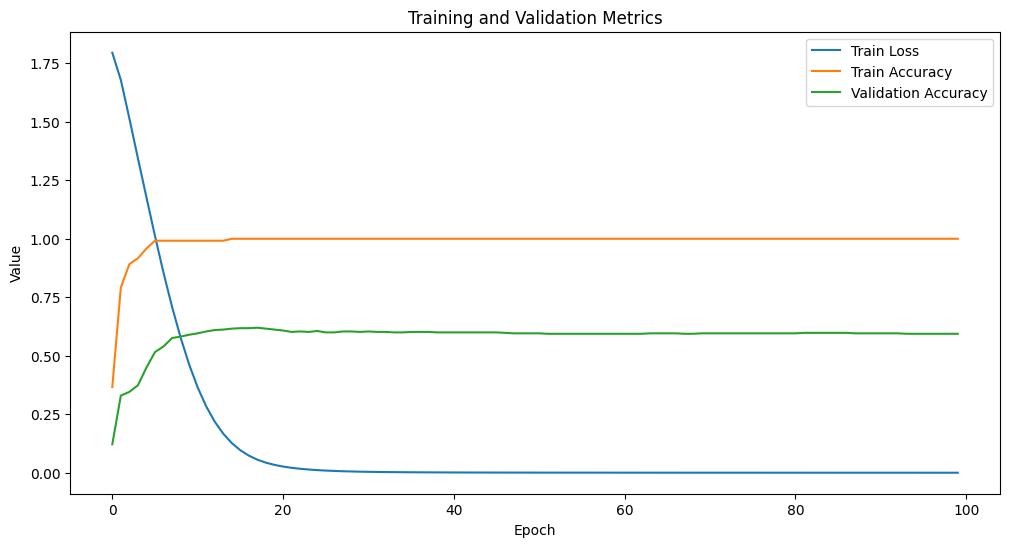

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data.num_features, 16, dataset.num_classes).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(100):
    loss = train(model, data, optimizer, criterion, data.train_mask)
    train_acc = test(model, data, data.train_mask)
    val_acc = test(model, data, data.val_mask)

    train_losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Plot metrics
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training and Validation Metrics")
plt.legend()
plt.show()


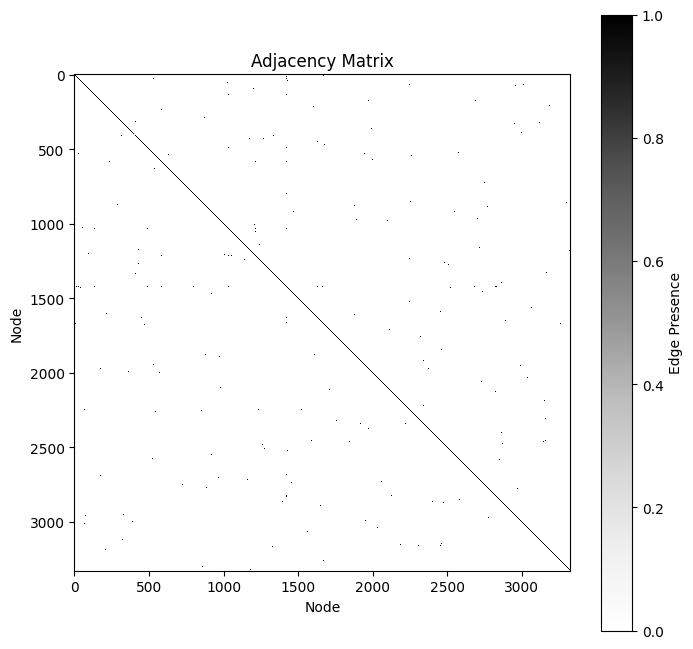

In [53]:
def visualize_adjacency(edge_index, num_nodes):
    """
    Visualizes the adjacency matrix of the graph.
    """
    adj_matrix = torch.zeros((num_nodes, num_nodes))
    adj_matrix[edge_index[0], edge_index[1]] = 1
    adj_matrix += torch.eye(num_nodes)
    plt.figure(figsize=(8, 8))
    plt.imshow(adj_matrix.numpy(), cmap='Greys', interpolation='none')
    plt.title("Adjacency Matrix")
    plt.colorbar(label="Edge Presence")
    plt.xlabel("Node")
    plt.ylabel("Node")
    plt.show()

visualize_adjacency(data.edge_index, data.num_nodes)

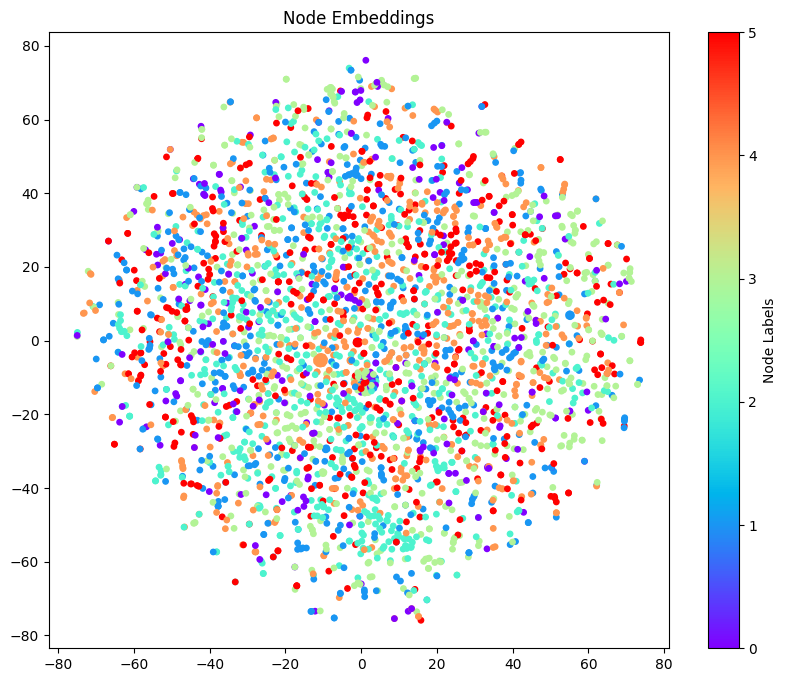

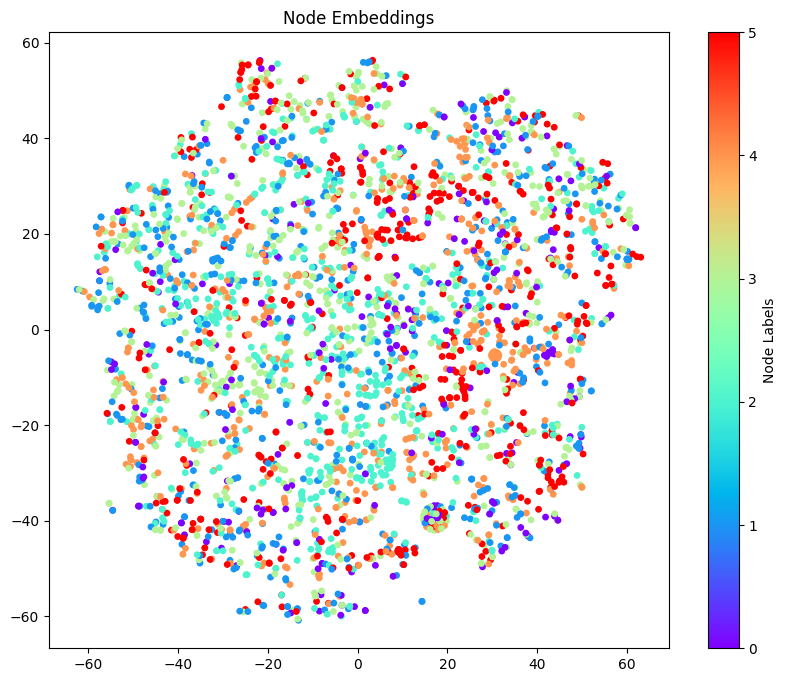

In [55]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, labels, method='PCA', title='Node Embeddings'):
    """
    Visualize high-dimensional node embeddings using PCA or t-SNE.
    """
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported reduction method. Choose 'PCA' or 't-SNE'.")

    reduced_embeddings = reducer.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
        c=labels, cmap=plt.cm.rainbow, s=15
    )
    plt.colorbar(scatter, label="Node Labels")
    plt.title(title)
    plt.show()

# Forward pass to get node embeddings
model = GCN(data.num_features, 16, dataset.num_classes)
with torch.no_grad():
    embeddings1 = model.gcn1(data.x, data.edge_index)
    visualize_embeddings(embeddings1.numpy(), data.y.numpy(), method='t-SNE')

    embeddings2 = model.gcn2(embeddings1, data.edge_index)
    visualize_embeddings(embeddings2.numpy(), data.y.numpy(), method='t-SNE')


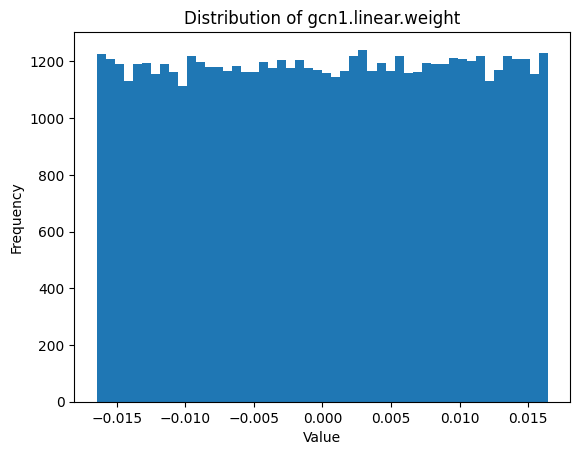

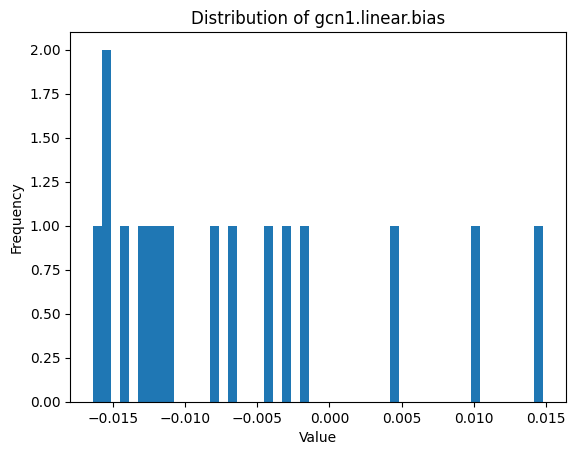

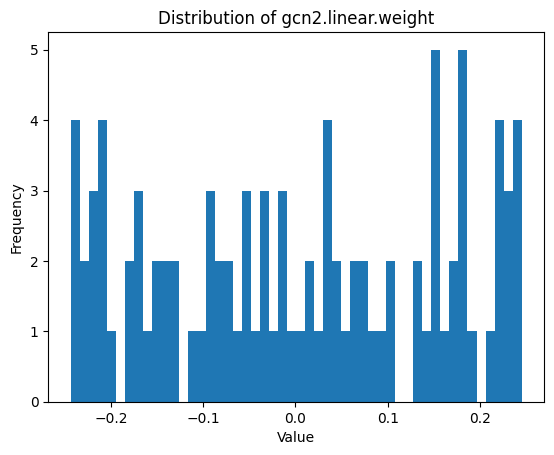

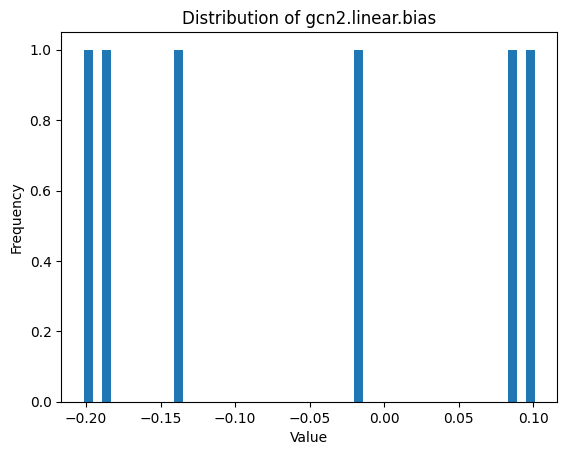

In [56]:
def visualize_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            plt.figure()
            plt.hist(param.detach().cpu().numpy().flatten(), bins=50)
            plt.title(f"Distribution of {name}")
            plt.xlabel("Value")
            plt.ylabel("Frequency")
            plt.show()

visualize_parameters(model)


In [60]:
# Save the trained model
torch.save(model.state_dict(), "gcn_model.pth")
print("Model saved to gcn_model.pth")


Model saved to gcn_model.pth


**Recreate the model architecture**

model = GCN(data.num_features, 16, dataset.num_classes)

model.load_state_dict(torch.load("gcn_model.pth"))

model.eval()  # Set the model to evaluation mode

print("Model loaded from gcn_model.pth")
